In [1]:
import os
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
from xgboost import XGBRegressor
from sklearn.preprocessing import LabelEncoder

plt.rcParams['font.family'] = 'AppleGothic' # matplotlib 한글 폰트깨짐 문제 해결을 위함
cur_path = '.'
data_path = 'data'
train_file_name = 'train.csv'
test_file_name = 'test.csv'
submission_file_name = 'sample_submission.csv'

In [2]:
train_raw = pd.read_csv(os.path.join(cur_path, data_path, train_file_name), encoding='utf-8')
test_raw = pd.read_csv(os.path.join(cur_path, data_path, test_file_name), encoding='utf-8')

# raw 코드 살펴보기

In [3]:
train_raw

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원)
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02
...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40
7494,TRAIN_7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00


In [4]:
train_raw[(train_raw['모델'] == 'i5') & (train_raw['차량상태'] == 'Brand New')]['배터리용량']

37       NaN
40       NaN
60       NaN
116      NaN
152      NaN
        ... 
7293     NaN
7318     NaN
7326     NaN
7386     NaN
7444    90.0
Name: 배터리용량, Length: 88, dtype: float64

In [5]:
train_raw.describe().T

,count,mean,std,min,25%,50%,75%,max
배터리용량,4786.0,69.397187,15.283635,46.0,56.359,68.125,78.227,99.80
주행거리(km),7497.0,44287.979458,55204.064386,3.0,5465.000,17331.000,61252.000,199827.00
보증기간(년),7497.0,4.960918,3.155342,0.0,2.000,5.000,8.000,10.00
연식(년),7497.0,0.222489,0.569232,0.0,0.000,0.000,0.000,2.00
가격(백만원),7497.0,62.331949,36.646759,9.0,34.390,56.000,80.050,161.09


## 결측치 존재하는 column 확인 -> 배터리용량 column에 결측치 존재 확인

In [6]:
train_raw.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7497 entries, 0 to 7496
Data columns (total 11 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   ID        7497 non-null   object 
 1   제조사       7497 non-null   object 
 2   모델        7497 non-null   object 
 3   차량상태      7497 non-null   object 
 4   배터리용량     4786 non-null   float64
 5   구동방식      7497 non-null   object 
 6   주행거리(km)  7497 non-null   int64  
 7   보증기간(년)   7497 non-null   int64  
 8   사고이력      7497 non-null   object 
 9   연식(년)     7497 non-null   int64  
 10  가격(백만원)   7497 non-null   float64
dtypes: float64(2), int64(3), object(6)
memory usage: 644.4+ KB


In [7]:
train_raw.isna().sum() # 결측치 확인

ID             0
제조사            0
모델             0
차량상태           0
배터리용량       2711
구동방식           0
주행거리(km)       0
보증기간(년)        0
사고이력           0
연식(년)          0
가격(백만원)        0
dtype: int64

## numeric type column간 상관관계 확인

In [8]:
train_raw.corr(numeric_only=True).T

,배터리용량,주행거리(km),보증기간(년),연식(년),가격(백만원)
배터리용량,1.000000,-0.576538,0.558242,-0.021845,0.431668
주행거리(km),-0.576538,1.000000,-0.664071,-0.089586,-0.035488
보증기간(년),0.558242,-0.664071,1.000000,0.035294,-0.349962
연식(년),-0.021845,-0.089586,0.035294,1.000000,-0.058455
가격(백만원),0.431668,-0.035488,-0.349962,-0.058455,1.000000


# Test 파일 확인

In [9]:
test_raw

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년)
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0
2,TEST_002,B사,i5,Brand New,NaN,RWD,7197,7,Yes,0
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1
4,TEST_004,K사,EV6,Brand New,NaN,FWD,7597,10,No,0
...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,P사,TayGTS,Pre-Owned,64.683,AWD,117298,2,No,0
842,TEST_842,V사,ID4,Pre-Owned,55.547,AWD,72308,0,No,0
843,TEST_843,V사,ID4,Pre-Owned,55.547,AWD,124537,0,No,0
844,TEST_844,A사,Q4eT,Nearly New,69.646,AWD,15629,4,No,0


In [10]:
test_raw.isna().sum()

ID            0
제조사           0
모델            0
차량상태          0
배터리용량       304
구동방식          0
주행거리(km)      0
보증기간(년)       0
사고이력          0
연식(년)         0
dtype: int64

# Data Preprocessing

### Column '배터리용량' - 결측치 존재O 
- 연속형 변수
- 결측치 처리
    - 차량상태 별 평균으로 채우기

### Column '주행거리(km)' 
- 연속형 변수
- 분포에 outlier가 많이 보이므로 구간별로 나누는 방법 사용

### Column '제조사'
- 명목형 변수
- 제조사 종류가 많으므로 Label Encoding

### Column '모델'
- 명목형 변수 
- 제조사 종류가 많으므로 Label Encoding

### Column 차량상태
- 주행거리가 큰 의미를 가지므로 사용X

### Column 보증기간(년), 연식(년) 
- 이산형 변수로 그대로 사용

In [11]:
tmp = train_raw.groupby(['차량상태','모델'])[['배터리용량']].mean()
tmp

배터리용량
차량상태       모델               
Brand New  EV6     90.000000
           ID4     90.000000
           ION5    90.000000
           ION6    90.000000
           KNE     90.000000
           M3      90.000000
           MS      97.688889
           MX      97.809524
           MY      90.000000
           Niro    90.000000
           Q4eT    90.000000
           RSeTGT  90.000000
           Soul    90.000000
           Tay     90.000000
           TayCT   90.000000
           TayGTS  92.790566
           eT      93.012644
           i3      90.000000
           i5      90.000000
           iX      90.000000
Nearly New ID4     66.740550
           ION5    67.240506
           ION6    67.292091
           IONIQ   62.126667
           KNE     68.488000
           M3      64.808630
           MS      89.834941
           MX      90.595217
           MY      65.259776
           Niro    56.818688
           Q4eT    71.442868
           RSeTGT  78.227000
           Soul    57.072050
           Tay     68.594303
           TayCT   76.093000
           TayGTS  78.062542
           eT      80.192745
           i3      56.000000
           i5      70.302392
Pre-Owned  ID4     56.968825
           ION5    56.633083
           ION6    57.226545
           IONIQ   61.970702
           KNE     68.488000
           M3      55.163056
           MS      73.022475
           MX      72.298143
           MY      55.141112
           Niro    47.766253
           Q4eT    60.076360
           RSeTGT  78.227000
           Soul    47.479583
           Tay     57.891596
           TayCT   76.093000
           TayGTS  69.093600
           eT      69.948379
           i3      46.000000
           i5      59.657726

In [12]:
grouped_capacity_means = tmp.T.unstack(level = 0).reset_index()
grouped_capacity_means

,차량상태,모델,level_2,0
0,Brand New,EV6,배터리용량,90.000000
1,Brand New,ID4,배터리용량,90.000000
2,Brand New,ION5,배터리용량,90.000000
3,Brand New,ION6,배터리용량,90.000000
4,Brand New,KNE,배터리용량,90.000000
5,Brand New,M3,배터리용량,90.000000
6,Brand New,MS,배터리용량,97.688889
7,Brand New,MX,배터리용량,97.809524
8,Brand New,MY,배터리용량,90.000000
9,Brand New,Niro,배터리용량,90.000000


In [13]:
grouped_capacity_means['차량상태 및 모델별 평균'] = grouped_capacity_means[0]
grouped_capacity_means.drop(['level_2', 0], axis = 1, inplace = True)
grouped_capacity_means

,차량상태,모델,차량상태 및 모델별 평균
0,Brand New,EV6,90.000000
1,Brand New,ID4,90.000000
2,Brand New,ION5,90.000000
3,Brand New,ION6,90.000000
4,Brand New,KNE,90.000000
5,Brand New,M3,90.000000
6,Brand New,MS,97.688889
7,Brand New,MX,97.809524
8,Brand New,MY,90.000000
9,Brand New,Niro,90.000000


In [14]:
train = pd.merge(train_raw, grouped_capacity_means, on = ['차량상태', '모델'], how = 'left')


In [15]:
train

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),차량상태 및 모델별 평균
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,78.062542
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,56.818688
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,93.012644
3,TRAIN_0003,A사,RSeTGT,Nearly New,NaN,AWD,21683,3,No,0,99.16,78.227000
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02,59.657726
...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,NaN,AWD,3773,10,No,0,35.95,90.000000
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40,46.000000
7494,TRAIN_7494,P사,TayCT,Brand New,NaN,AWD,1363,2,No,0,120.00,90.000000
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00,56.000000


In [16]:
train.isna().sum()

ID                  0
제조사                 0
모델                  0
차량상태                0
배터리용량            2711
구동방식                0
주행거리(km)            0
보증기간(년)             0
사고이력                0
연식(년)               0
가격(백만원)             0
차량상태 및 모델별 평균       0
dtype: int64

In [17]:
train['배터리용량'] = train['배터리용량'].fillna(train['차량상태 및 모델별 평균'])

In [18]:
train.isna().sum()

ID               0
제조사              0
모델               0
차량상태             0
배터리용량            0
구동방식             0
주행거리(km)         0
보증기간(년)          0
사고이력             0
연식(년)            0
가격(백만원)          0
차량상태 및 모델별 평균    0
dtype: int64

In [19]:
test = pd.merge(test_raw, grouped_capacity_means, on = ['차량상태', '모델'], how = 'left')
test['배터리용량'] = test['배터리용량'].fillna(test['차량상태 및 모델별 평균'])

In [20]:
def fill_battery_capacity(row, groupby_col, fill_col, model_means, global_mean):
    if pd.isna(row[fill_col]):
        if row[groupby_col] in model_means:
            return model_means[row[groupby_col]]
        else:
            return global_mean
        
    return row['배터리용량']
model_battery_means = train.groupby('차량상태')['배터리용량'].mean()
global_capacity_mean = train['배터리용량'].mean()

train['배터리용량'] = train.apply(
    lambda row: fill_battery_capacity(row, '차량상태', '배터리용량', model_battery_means, global_capacity_mean),
    axis = 1
)

test['배터리용량'] = test.apply(
    lambda row: fill_battery_capacity(row, '차량상태', '배터리용량' , model_battery_means, global_capacity_mean),
    axis = 1
)

In [21]:
train.isna().sum() #결측치(잔여) 존재여부 확인

ID               0
제조사              0
모델               0
차량상태             0
배터리용량            0
구동방식             0
주행거리(km)         0
보증기간(년)          0
사고이력             0
연식(년)            0
가격(백만원)          0
차량상태 및 모델별 평균    0
dtype: int64

In [22]:
test.isna().sum() #결측치(잔여) 존재여부 확인

ID               0
제조사              0
모델               0
차량상태             0
배터리용량            0
구동방식             0
주행거리(km)         0
보증기간(년)          0
사고이력             0
연식(년)            0
차량상태 및 모델별 평균    0
dtype: int64

In [23]:
train

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),차량상태 및 모델별 평균
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,78.062542
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,56.818688
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,93.012644
3,TRAIN_0003,A사,RSeTGT,Nearly New,78.227,AWD,21683,3,No,0,99.16,78.227000
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02,59.657726
...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,90.000,AWD,3773,10,No,0,35.95,90.000000
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40,46.000000
7494,TRAIN_7494,P사,TayCT,Brand New,90.000,AWD,1363,2,No,0,120.00,90.000000
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00,56.000000


In [24]:
test

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),차량상태 및 모델별 평균
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0,76.093000
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0,90.000000
2,TEST_002,B사,i5,Brand New,90.000,RWD,7197,7,Yes,0,90.000000
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1,67.240506
4,TEST_004,K사,EV6,Brand New,90.000,FWD,7597,10,No,0,90.000000
...,...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,P사,TayGTS,Pre-Owned,64.683,AWD,117298,2,No,0,69.093600
842,TEST_842,V사,ID4,Pre-Owned,55.547,AWD,72308,0,No,0,56.968825
843,TEST_843,V사,ID4,Pre-Owned,55.547,AWD,124537,0,No,0,56.968825
844,TEST_844,A사,Q4eT,Nearly New,69.646,AWD,15629,4,No,0,71.442868


# Numeric Type Column들 - Outlier 확인 및 처리를 위해 그래프 생성

## 주행거리(km) 컬럼
- 데이터를 그대로 사용하는 경우 데이터 왜곡 발생 위험이 있어 구간을 나눠 분리하기로 결정

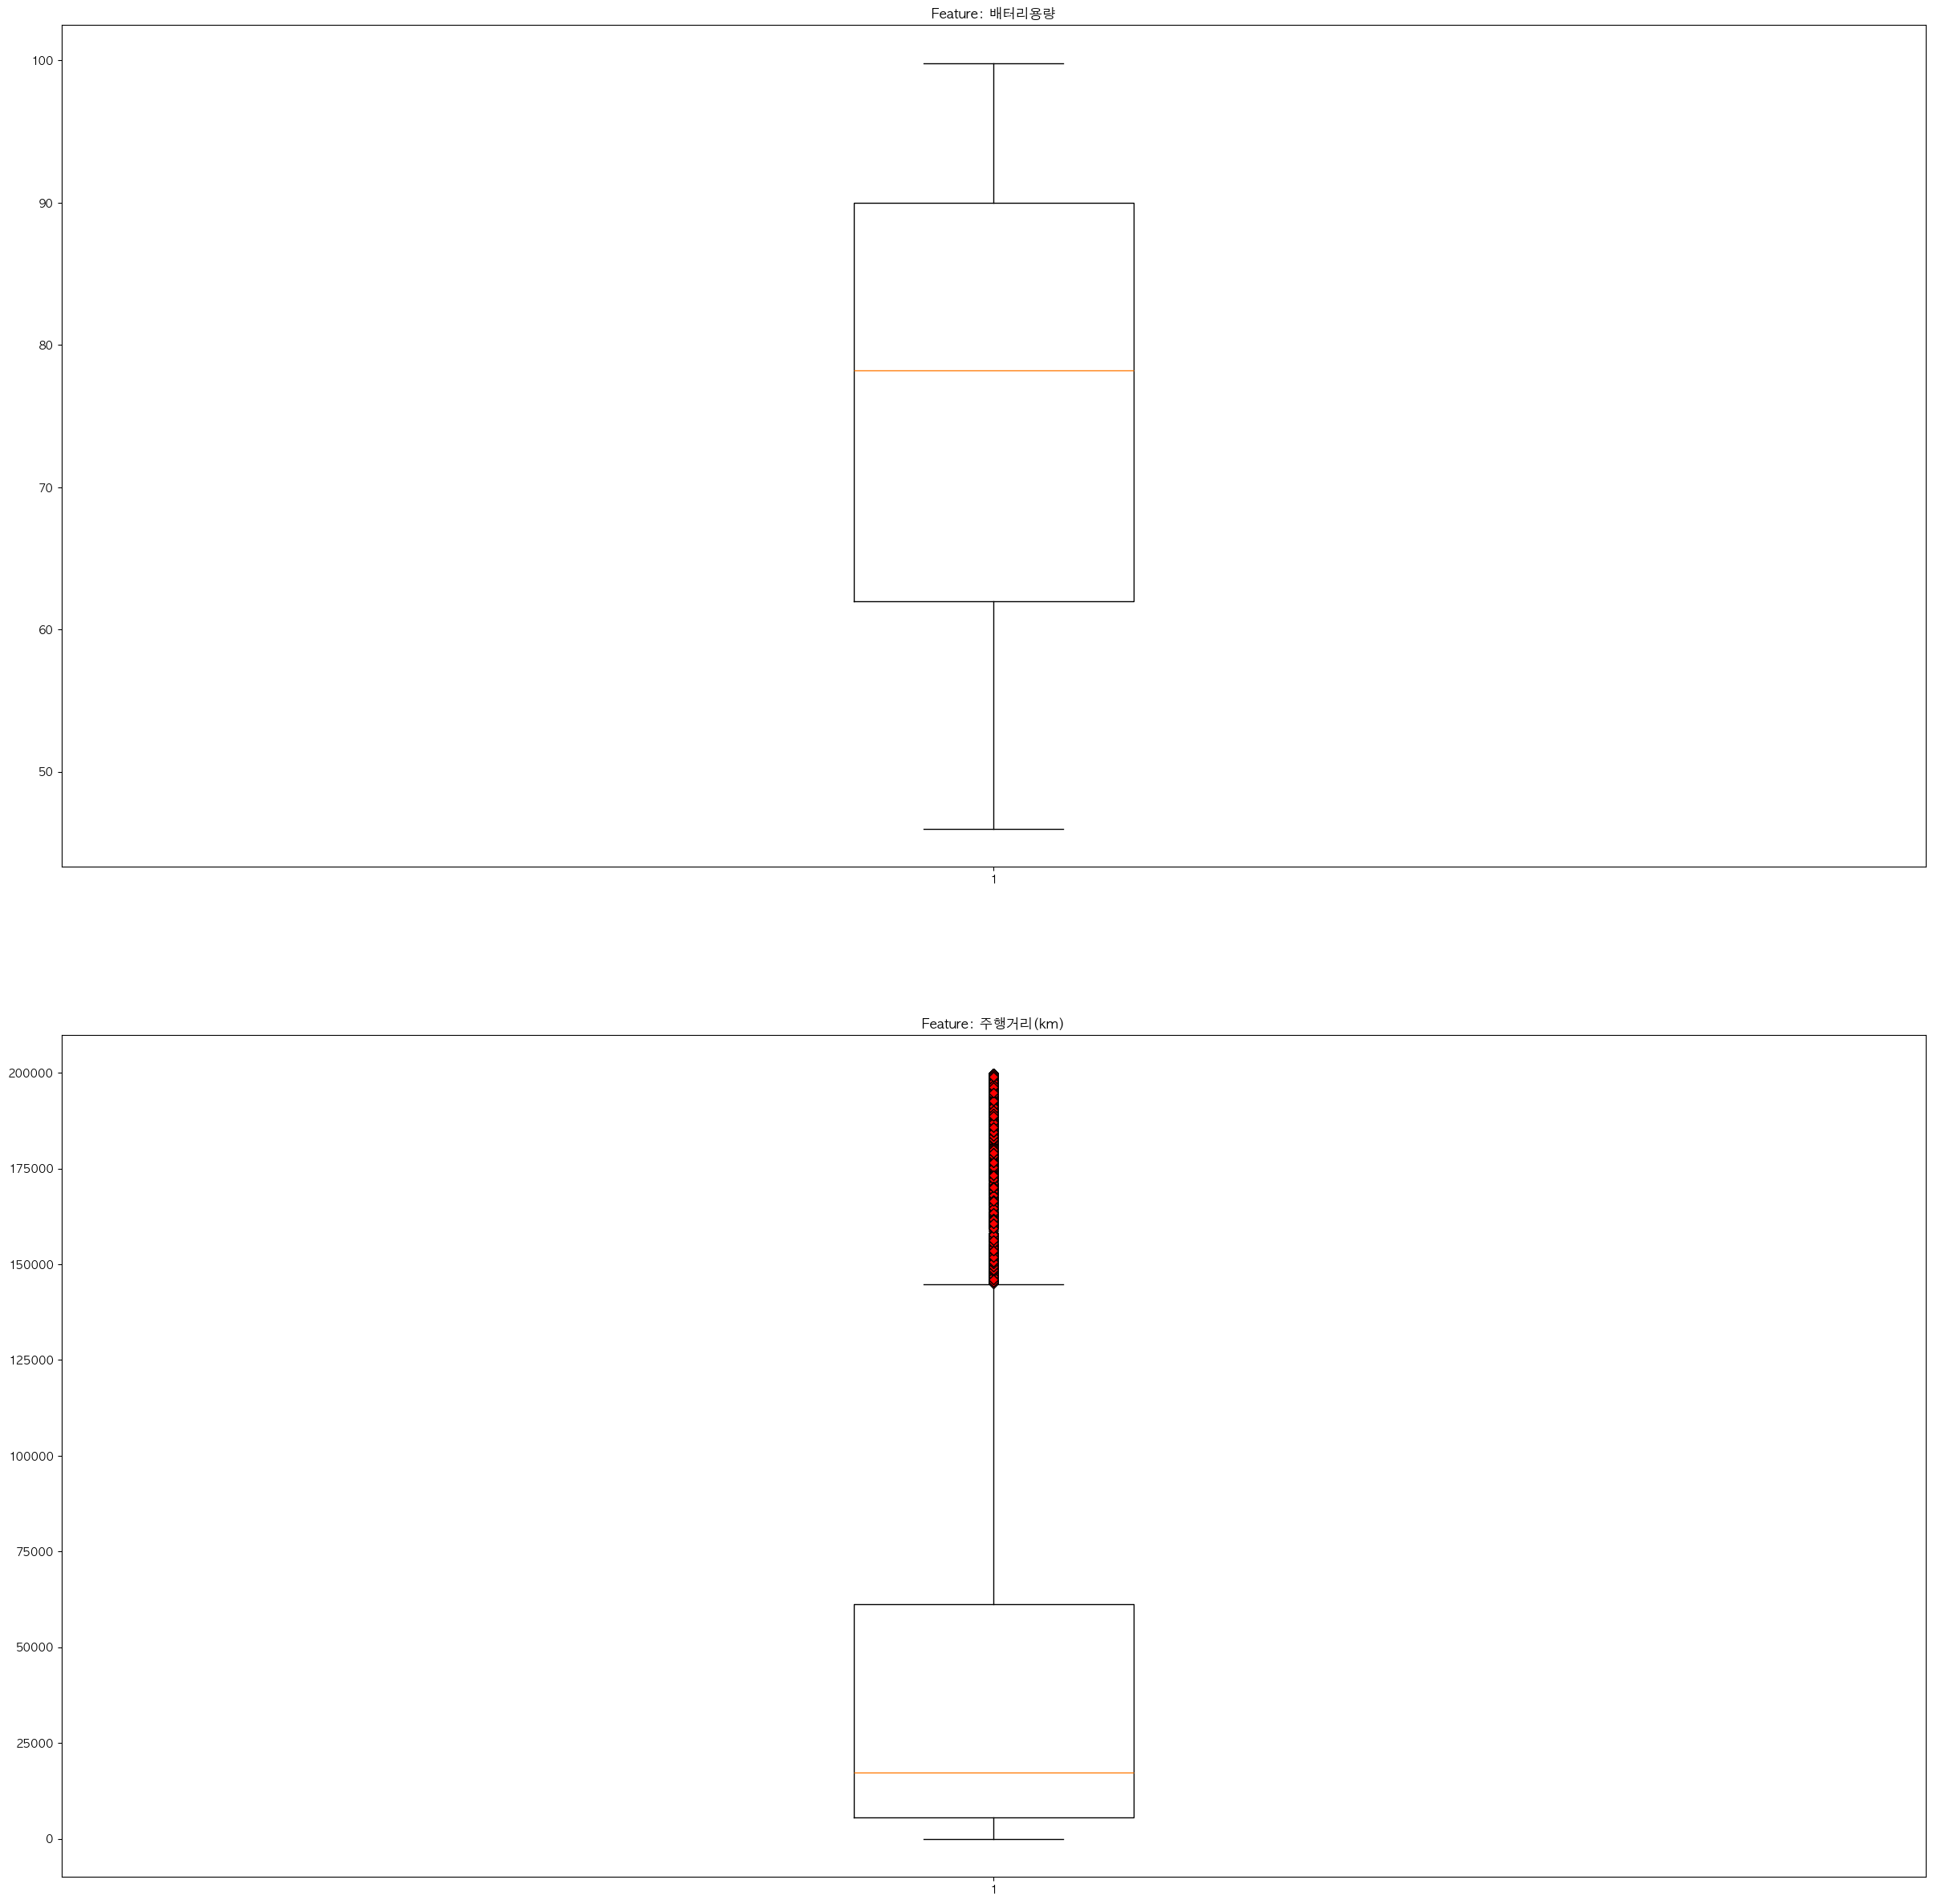

In [25]:
numeric_cols = ['배터리용량', '주행거리(km)']
plt.figure(figsize=(30, 30))
col_idx = 0
for col in numeric_cols:
    col_idx += 1
    plt.subplot(2, 1, col_idx)
    plt.boxplot(train[[col]], flierprops= dict(markerfacecolor = 'r', marker = 'D'))
    plt.title(f'Feature: {col}')

Text(0.5, 1.0, '주행거리(km) - 분포')

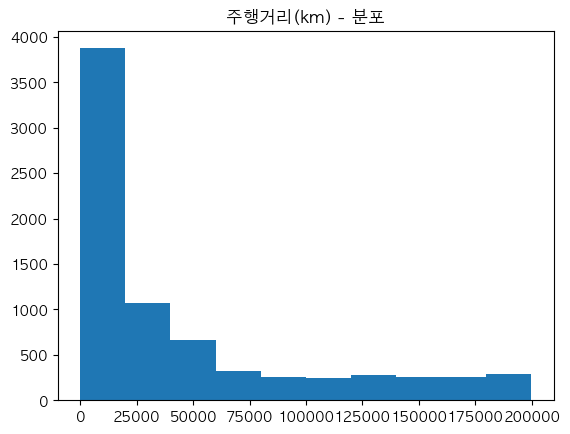

In [26]:
plt.hist(
    x = train['주행거리(km)']

)
plt.title('주행거리(km) - 분포')

## Column 주행거리(km) Binning
- 중고차 시장에서는 3만 km 이하, 7만 km 이하, 10만 km 이하, 10만 km 초과로 분리하기도 함
- train 데이터를 고려하여 차량상태별, 그리고 차량상태의 중위수를 바탕으로 6개 그룹으로 분리

In [27]:
train.groupby('차량상태').describe()[['주행거리(km)']].T

차량상태              Brand New    Nearly New      Pre-Owned
주행거리(km) count  3380.000000   2059.000000    2058.000000
         mean   4935.953550  30602.352113  122610.892128
         std    2897.745303  12257.976737   45517.411096
         min       3.000000  10004.000000   11477.000000
         25%    2372.750000  20499.000000   82717.000000
         50%    4980.000000  30453.000000  123352.500000
         75%    7440.750000  40270.000000  161763.500000
         max    9999.000000  79226.000000  199827.000000

In [28]:
bin = [0, 5000, 10000, 30000, 80000, 120000, float('inf')]
label = ['5000km 이하', '10000km 이하', '30000km 이하', '80000km 이하', '120000km 이하', '120000km 초과']

train['주행거리구간별'] = pd.cut(train['주행거리(km)'], bins = bin, labels = label)
train

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),가격(백만원),차량상태 및 모델별 평균,주행거리구간별
0,TRAIN_0000,P사,TayGTS,Nearly New,86.077,AWD,13642,0,No,2,159.66,78.062542,30000km 이하
1,TRAIN_0001,K사,Niro,Nearly New,56.000,FWD,10199,6,No,0,28.01,56.818688,30000km 이하
2,TRAIN_0002,A사,eT,Brand New,91.200,AWD,2361,7,No,0,66.27,93.012644,5000km 이하
3,TRAIN_0003,A사,RSeTGT,Nearly New,78.227,AWD,21683,3,No,0,99.16,78.227000,30000km 이하
4,TRAIN_0004,B사,i5,Pre-Owned,61.018,AWD,178205,1,No,0,62.02,59.657726,120000km 초과
...,...,...,...,...,...,...,...,...,...,...,...,...,...
7492,TRAIN_7492,H사,ION5,Brand New,90.000,AWD,3773,10,No,0,35.95,90.000000,5000km 이하
7493,TRAIN_7493,B사,i3,Pre-Owned,46.000,RWD,135411,2,No,0,23.40,46.000000,120000km 초과
7494,TRAIN_7494,P사,TayCT,Brand New,90.000,AWD,1363,2,No,0,120.00,90.000000,5000km 이하
7495,TRAIN_7495,B사,i3,Nearly New,56.000,RWD,39445,6,No,2,24.00,56.000000,80000km 이하


In [29]:
test['주행거리구간별'] = pd.cut(train['주행거리(km)'], bins = bin, labels = label)
test

,ID,제조사,모델,차량상태,배터리용량,구동방식,주행거리(km),보증기간(년),사고이력,연식(년),차량상태 및 모델별 평균,주행거리구간별
0,TEST_000,P사,TayCT,Nearly New,76.093,AWD,14057,2,No,0,76.093000,30000km 이하
1,TEST_001,B사,iX,Brand New,90.000,AWD,7547,8,No,0,90.000000,30000km 이하
2,TEST_002,B사,i5,Brand New,90.000,RWD,7197,7,Yes,0,90.000000,5000km 이하
3,TEST_003,H사,ION5,Nearly New,68.479,AWD,10357,7,No,1,67.240506,30000km 이하
4,TEST_004,K사,EV6,Brand New,90.000,FWD,7597,10,No,0,90.000000,120000km 초과
...,...,...,...,...,...,...,...,...,...,...,...,...
841,TEST_841,P사,TayGTS,Pre-Owned,64.683,AWD,117298,2,No,0,69.093600,10000km 이하
842,TEST_842,V사,ID4,Pre-Owned,55.547,AWD,72308,0,No,0,56.968825,120000km 초과
843,TEST_843,V사,ID4,Pre-Owned,55.547,AWD,124537,0,No,0,56.968825,120000km 이하
844,TEST_844,A사,Q4eT,Nearly New,69.646,AWD,15629,4,No,0,71.442868,80000km 이하


In [30]:
X_train = train.drop(['ID', '가격(백만원)', '차량상태', '주행거리(km)','차량상태 및 모델별 평균'], axis = 1)
X_test = test.drop(['ID', '차량상태', '주행거리(km)', '차량상태 및 모델별 평균'], axis = 1)

y_train = train['가격(백만원)']

In [31]:
X_train

,제조사,모델,배터리용량,구동방식,보증기간(년),사고이력,연식(년),주행거리구간별
0,P사,TayGTS,86.077,AWD,0,No,2,30000km 이하
1,K사,Niro,56.000,FWD,6,No,0,30000km 이하
2,A사,eT,91.200,AWD,7,No,0,5000km 이하
3,A사,RSeTGT,78.227,AWD,3,No,0,30000km 이하
4,B사,i5,61.018,AWD,1,No,0,120000km 초과
...,...,...,...,...,...,...,...,...
7492,H사,ION5,90.000,AWD,10,No,0,5000km 이하
7493,B사,i3,46.000,RWD,2,No,0,120000km 초과
7494,P사,TayCT,90.000,AWD,2,No,0,5000km 이하
7495,B사,i3,56.000,RWD,6,No,2,80000km 이하


In [32]:
y_train

0       159.66
1        28.01
2        66.27
3        99.16
4        62.02
         ...  
7492     35.95
7493     23.40
7494    120.00
7495     24.00
7496     74.06
Name: 가격(백만원), Length: 7497, dtype: float64

In [33]:


categorical_features = ['제조사', '모델', '구동방식', '사고이력','주행거리구간별']
# categorical_features = ['제조사', '모델',  '사고이력','주행거리구간별']

for i in categorical_features:
    le = LabelEncoder()
    le=le.fit(X_train[i]) 
    X_train[i]=le.transform(X_train[i])
    
    for case in np.unique(X_test[i]):
        if case not in le.classes_: 
            le.classes_ = np.append(le.classes_, case) 
    X_test[i]=le.transform(X_test[i])
    
display(X_train.head())

,제조사,모델,배터리용량,구동방식,보증기간(년),사고이력,연식(년),주행거리구간별
0,4,16,86.077,0,0,0,2,3
1,3,10,56.000,1,6,0,0,3
2,0,17,91.200,0,7,0,0,4
3,0,12,78.227,0,3,0,0,3
4,1,19,61.018,0,1,0,0,2


In [34]:


xgb_regressor = XGBRegressor(
    random_state = 100, 
    learning_rate = 0.1,
    max_depth = 5,
    n_estimators = 100
    )

In [35]:
xgb_regressor.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=100, ...)

In [36]:
xgb_regressor.score(X_train, y_train)

0.9988452959073252

In [37]:
y_test = xgb_regressor.predict(X_test)

In [38]:
submission = pd.read_csv(os.path.join(cur_path, data_path, submission_file_name),encoding='utf-8')


In [39]:
submission['가격(백만원)'] = y_test
submission.head()

,ID,가격(백만원)
0,TEST_000,128.946350
1,TEST_001,80.065010
2,TEST_002,64.670006
3,TEST_003,34.798004
4,TEST_004,47.726704


In [40]:
submission.to_csv('./my_submission_final.csv',index=False)